# Easy Alignment with GRPO
## From PPO to Group Relative Policy Optimization

> **Goal**: Understand how GRPO works by building from PPO foundations, then training a small policy to sort 3 numbers.

| Section | Topic |
|---|---|
| Part 1 | PPO — background, objective, algorithm |
| Part 2 | GRPO — key insight, equations, algorithm |
| Part 3 | Demo — train a policy to sort `[1, 0, 2]` → `[0, 1, 2]` |

---
## Part 1: Proximal Policy Optimization (PPO)

**Reference:** Schulman et al., *Proximal Policy Optimization Algorithms*, arXiv:1707.06347 (2017)

---

### 1.1 Problem Setup

In reinforcement learning we have:
- **Policy** $\pi_\theta(a \mid s)$: the probability of taking action $a$ in state $s$
- **Reward** $r_t$: scalar feedback from the environment at timestep $t$
- **Advantage** $\hat{A}_t$: how much better (or worse) action $a_t$ was compared to the average

Our goal: maximize expected cumulative reward by updating $\theta$.

---

### 1.2 Vanilla Policy Gradient (REINFORCE)

The basic policy gradient update:

$$\nabla_\theta J(\theta) = \mathbb{E}_t\left[\nabla_\theta \log \pi_\theta(a_t \mid s_t) \cdot \hat{A}_t\right]$$

**Problem**: Each gradient step can be too large → the policy "collapses" or becomes unstable.

---

### 1.3 PPO Clipped Objective

PPO constrains how much the policy can change in a single update using a **clipped surrogate objective**.

Define the **importance ratio**:

$$r_t(\theta) = \frac{\pi_\theta(a_t \mid s_t)}{\pi_{\theta_{\text{old}}}(a_t \mid s_t)}$$

The PPO objective clips this ratio to stay within $[1-\epsilon,\; 1+\epsilon]$:

$$\boxed{L^{\text{CLIP}}(\theta) = \mathbb{E}_t\!\left[\min\!\left(r_t(\theta)\,\hat{A}_t,\;\text{clip}\!\left(r_t(\theta),\,1\!-\!\epsilon,\,1\!+\!\epsilon\right)\hat{A}_t\right)\right]}$$

Intuition:
- If $\hat{A}_t > 0$ (good action): push up $\pi_\theta$, but cap the ratio at $1+\epsilon$
- If $\hat{A}_t < 0$ (bad action): push down $\pi_\theta$, but floor the ratio at $1-\epsilon$

The full PPO objective also includes a value function loss $L^{\text{VF}}$ and entropy bonus $S$:

$$L^{\text{PPO}}(\theta) = \mathbb{E}_t\left[L^{\text{CLIP}}_t - c_1\,L^{\text{VF}}_t + c_2\,S[\pi_\theta](s_t)\right]$$

where $c_1, c_2$ are coefficients.

---

### 1.4 Advantage Estimation (GAE)

PPO uses **Generalized Advantage Estimation** (Schulman et al., 2015):

$$\hat{A}_t^{\text{GAE}(\gamma,\lambda)} = \sum_{l=0}^{\infty}(\gamma\lambda)^l\,\delta_{t+l}, \qquad \delta_t = r_t + \gamma\,V(s_{t+1}) - V(s_t)$$

> **Key requirement**: PPO needs a separate **value function (critic)** $V(s)$ to estimate $\hat{A}_t$.  
> For large language models, training a value function is expensive — it needs a network as large as the policy.

---

### 1.5 PPO Algorithm

```
Algorithm 1: PPO (clip variant)
─────────────────────────────────────────────────────────────────
Input: initial policy π_θ, value function V_φ, clip ε

for iteration = 1, 2, ... do
    // Collect trajectories
    for actor = 1, ..., N do
        Run π_θ_old for T timesteps → {s_t, a_t, r_t}
    end

    // Compute advantages
    Compute Â_t using GAE(γ, λ) with V_φ

    // Optimize for K epochs
    for epoch = 1, ..., K do
        for minibatch in trajectory do
            r_t(θ) = π_θ(a_t|s_t) / π_θ_old(a_t|s_t)
            L_CLIP = E[min(r_t(θ)·Â_t, clip(r_t(θ), 1-ε, 1+ε)·Â_t)]
            Update θ to maximize L_CLIP
            Update φ to minimize L_VF
        end
    end

    θ_old ← θ
end
─────────────────────────────────────────────────────────────────
```

### Visual Reference: PPO-Clip Algorithm

> *Source: Stanford CS336*

![PPO-Clip Algorithm](GRPO_al.png)

---
## Part 2: GRPO — Group Relative Policy Optimization

**Reference:** Shao et al., *DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models*, arXiv:2402.03300 (2024)

---

### 2.1 The Problem with PPO for LLMs

When aligning LLMs with PPO:

| Component | Cost |
|---|---|
| Policy model | ~7B parameters |
| Critic (value function) | ~7B parameters — **same size!** |
| Reference model | ~7B parameters |
| Reward model | ~7B parameters |

Running all 4 models simultaneously is expensive. Can we **eliminate the critic**?

---

### 2.2 GRPO's Key Insight: Group Sampling as a Baseline

> Instead of a value function, **sample a group of $G$ outputs** for the same input $q$,  
> and use the **group mean reward as the baseline**.

For each question $q$:

1. Sample $G$ outputs: $\{o^{(1)}, o^{(2)}, \ldots, o^{(G)}\} \sim \pi_{\theta_{\text{old}}}(\cdot \mid q)$
2. Compute rewards: $\{r^{(1)}, r^{(2)}, \ldots, r^{(G)}\}$ via reward function $R(q, o^{(i)})$
3. Normalize **within the group** to get advantages (Eq. 28):

$$\boxed{\hat{A}^{(i)} = \frac{r^{(i)} - \text{mean}\left(\{r^{(j)}\}_{j=1}^G\right)}{\text{std}\left(\{r^{(j)}\}_{j=1}^G\right)}}$$

No critic network needed!

---

### 2.3 GRPO Objective Function

$$\boxed{\mathcal{J}_{\text{GRPO}}(\theta) = \mathbb{E}_{\substack{q \sim \mathcal{D} \\ \{o^{(i)}\}_{i=1}^G \sim \pi_{\theta_{\text{old}}}}}\left[\frac{1}{G}\sum_{i=1}^{G}\frac{1}{|o^{(i)}|}\sum_{t=1}^{|o^{(i)}|}\left(\min\left(r_{i,t}(\theta)\,\hat{A}^{(i)},\;\text{clip}\left(r_{i,t}(\theta),1\!-\!\varepsilon,1\!+\!\varepsilon\right)\hat{A}^{(i)}\right) - \beta\,\mathbb{D}_{\text{KL}}\!\left[\pi_\theta \| \pi_{\text{ref}}\right]\right)\right]}$$

where the per-token importance ratio is:

$$r_{i,t}(\theta) = \frac{\pi_\theta(o^{(i)}_t \mid q,\, o^{(i)}_{<t})}{\pi_{\theta_{\text{old}}}(o^{(i)}_t \mid q,\, o^{(i)}_{<t})}$$

---

### 2.4 KL Divergence Penalty

The KL term keeps the policy close to a frozen reference model $\pi_{\text{ref}}$.

GRPO uses the **unbiased non-negative KL estimator** (per token):

$$\mathbb{D}_{\text{KL}}(\pi_\theta \| \pi_{\text{ref}}) = \frac{\pi_{\text{ref}}(o^{(i)}_t \mid q, o^{(i)}_{<t})}{\pi_\theta(o^{(i)}_t \mid q, o^{(i)}_{<t})} - \log\frac{\pi_{\text{ref}}(o^{(i)}_t \mid q, o^{(i)}_{<t})}{\pi_\theta(o^{(i)}_t \mid q, o^{(i)}_{<t})} - 1$$

In code (using log-probs $l_\theta$ and $l_{\text{ref}}$):
```python
kl = torch.exp(l_ref - l_theta) - (l_ref - l_theta) - 1
```

---

### 2.5 PPO vs GRPO: Key Differences

| | PPO | GRPO |
|---|---|---|
| Advantage source | Value function $V(s)$ | Group mean reward |
| Critic network | Required | **Not needed** |
| Baseline | Learned $V(s_t)$ | $\text{mean}(r^{(1)}, \ldots, r^{(G)})$ |
| Memory | 2× policy size | 1× policy size + ref |
| Suited for | General RL | LLM alignment |

---

### 2.6 GRPO Algorithm (Algorithm 3)

```
Algorithm 3: Group Relative Policy Optimization (GRPO)
─────────────────────────────────────────────────────────────────────────────
Input: initial policy model π_θ_init ; reward function R ; task questions D

 1: policy model π_θ ← π_θ_init
 2: for step = 1, ..., n_grpo_steps do
 3:     Sample a batch of questions D_b from D
 4:     Set the old policy model π_θ_old ← π_θ
 5:     Sample G outputs {o^(i)}_{i=1}^G ~ π_θ_old(· | q)  for each question q ∈ D_b
 6:     Compute rewards {r^(i)}_{i=1}^G for each sampled output o^(i)
            by running reward function R(q, o^(i))
 7:     Compute A^(i) with group normalization (Eq. 28):
            A^(i) = ( r^(i) − mean({r^(j)}) ) / std({r^(j)})
 8:     for train step = 1, ..., n_train_steps_per_rollout_batch do
 9:         Update the policy model π_θ by maximizing the GRPO-Clip objective (Eq. 29):
                J_GRPO(θ) = E[ min(r(θ)·A, clip(r(θ), 1−ε, 1+ε)·A) − β·D_KL(π_θ ‖ π_ref) ]
10:     end for
11: end for

Output: π_θ
─────────────────────────────────────────────────────────────────────────────
```

### Algorithm 3 — Paper Reference

![GRPO Algorithm 3](GRPO_algo.png)

### Visual Summary: PPO vs GRPO Architecture

> *Source: [DeepSeek's GRPO (Group Relative Policy Optimization)](https://www.youtube.com/watch?v=xT4jxQUl0X8)*  
> *PPO (top right): needs a critic $V_\phi$ to compute advantages from $s_t$ and $r_t$*  
> *GRPO (bottom right): samples a group of outputs, uses group rewards $r_i$ directly as the baseline — no critic needed*

![PPO vs GRPO Architecture](GRPO.png)

---
## Part 3: Demo — Sorting 3 Numbers with GRPO

### Task

```
prompt:   [1, 0, 2]
output:   [0, 1, 2]   ← correct (ascending order)
reward:   1.0         ← if sorted correctly, else 0.0
```

### Policy

A small neural network that maps 3 input numbers → probability over **6 permutations** of `[idx_0, idx_1, idx_2]`.

For input `[1, 0, 2]`, the correct answer is permutation `(1, 0, 2)` (position 1 first, then 0, then 2), which gives `[0, 1, 2]`.

### GRPO Setup

- For each input, sample **G=8 permutations** from the policy
- Reward each: `1.0` if sorted correctly, else `0.0`
- Normalize rewards within the group → advantages
- Update with clipped surrogate loss + KL penalty

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from itertools import permutations
import copy

torch.manual_seed(42)
random.seed(42)

# ── All permutations of 3 indices ──────────────────────────────
ALL_PERMS = list(permutations([0, 1, 2]))   # 6 permutations
PERM_TO_IDX = {p: i for i, p in enumerate(ALL_PERMS)}
NUM_PERMS = len(ALL_PERMS)

print("All possible output permutations:")
for i, p in enumerate(ALL_PERMS):
    print(f"  idx={i}  perm={p}")

All possible output permutations:
  idx=0  perm=(0, 1, 2)
  idx=1  perm=(0, 2, 1)
  idx=2  perm=(1, 0, 2)
  idx=3  perm=(1, 2, 0)
  idx=4  perm=(2, 0, 1)
  idx=5  perm=(2, 1, 0)


In [2]:
# ── Task helpers ───────────────────────────────────────────────

def generate_batch(batch_size: int = 16):
    """Random sorting problems: 3 distinct integers in [0, 9]"""
    return [random.sample(range(10), 3) for _ in range(batch_size)]


def normalize_input(nums):
    """
    Encode the relative order of the 3 numbers as a float vector.
    E.g. [1, 0, 2] → rank-based → [0.5, 0.0, 1.0]
    """
    order = sorted(range(3), key=lambda i: nums[i])   # indices by ascending value
    ranks = [0.0] * 3
    for rank, idx in enumerate(order):
        ranks[idx] = rank / 2.0          # 0.0, 0.5, 1.0
    return ranks


def correct_perm(nums) -> tuple:
    """The permutation of indices that sorts nums ascending."""
    return tuple(sorted(range(3), key=lambda i: nums[i]))


def reward_fn(nums, perm_idx: int) -> float:
    """
    Reward = 1.0 if perm_idx gives the ascending sort of nums, else 0.0
    """
    return 1.0 if ALL_PERMS[perm_idx] == correct_perm(nums) else 0.0


# Quick sanity check
nums = [1, 0, 2]
cp = correct_perm(nums)
cidx = PERM_TO_IDX[cp]
print(f"Input:          {nums}")
print(f"Correct perm:   {cp}  (idx={cidx})")
print(f"Sorted output:  {[nums[i] for i in cp]}")
print(f"Reward(correct):{reward_fn(nums, cidx)}")
print(f"Reward(wrong):  {reward_fn(nums, 0)}")

Input:          [1, 0, 2]
Correct perm:   (1, 0, 2)  (idx=2)
Sorted output:  [0, 1, 2]
Reward(correct):1.0
Reward(wrong):  0.0


In [3]:
# ── Policy network ─────────────────────────────────────────────

class SortPolicy(nn.Module):
    """
    Maps a normalized 3-vector → probability distribution over 6 permutations.
    Analogy to an LLM: input = prompt, output = distribution over possible answers.
    """
    def __init__(self, hidden: int = 32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, NUM_PERMS),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Returns probability distribution (softmax) over 6 permutations."""
        return torch.softmax(self.net(x), dim=-1)

    def log_probs(self, x: torch.Tensor) -> torch.Tensor:
        """Returns log-probabilities over 6 permutations."""
        return torch.log_softmax(self.net(x), dim=-1)


# Initialise policy and frozen reference policy (π_ref)
policy    = SortPolicy(hidden=32)
ref_policy = copy.deepcopy(policy)          # frozen copy
for p in ref_policy.parameters():
    p.requires_grad = False

print("Policy architecture:")
print(policy)
print(f"\nParameters: {sum(p.numel() for p in policy.parameters())}")

Policy architecture:
SortPolicy(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=6, bias=True)
  )
)

Parameters: 1382


In [4]:
# ── GRPO step ──────────────────────────────────────────────────

def grpo_step(
    policy: SortPolicy,
    ref_policy: SortPolicy,
    optimizer: optim.Optimizer,
    problems: list,
    G: int   = 8,      # group size
    eps: float = 0.2,  # clip range
    beta: float = 0.01 # KL coefficient
) -> tuple:
    """
    One GRPO update step.

    For each question q:
      1. Sample G outputs from old policy
      2. Compute rewards r_1 ... r_G
      3. Group-normalize → advantages  Â_i = (r_i - mean) / std
      4. Clipped surrogate loss + KL penalty
      5. Average over group and batch, backprop
    """
    policy.train()
    all_problem_losses = []
    total_reward = 0.0

    for nums in problems:
        x = torch.tensor(normalize_input(nums), dtype=torch.float32)  # shape [3]

        # ── Step 1: Sample G outputs from current (old) policy ───
        with torch.no_grad():
            old_log_p = policy.log_probs(x)           # [6]
            old_probs  = torch.exp(old_log_p)
            samples    = torch.multinomial(old_probs, G, replacement=True)  # [G]

        # ── Step 2: Rewards ──────────────────────────────────────
        rewards = torch.tensor(
            [reward_fn(nums, s.item()) for s in samples],
            dtype=torch.float32
        )  # [G]
        total_reward += rewards.mean().item()

        # ── Step 3: Group-normalize → advantages ─────────────────
        #
        #   Â_i = (r_i - mean({r_j})) / std({r_j})
        #
        advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-8)  # [G]

        # ── Step 4: GRPO loss ─────────────────────────────────────
        curr_log_p = policy.log_probs(x)              # [6]  (tracks grad)
        ref_log_p  = ref_policy.log_probs(x).detach() # [6]  (frozen)

        group_losses = []
        for i, (s_idx, adv) in enumerate(zip(samples, advantages)):
            # Importance ratio: π_θ(o) / π_θ_old(o)
            ratio = torch.exp(curr_log_p[s_idx] - old_log_p[s_idx].detach())

            # Clipped surrogate (same as PPO)
            clipped  = torch.clamp(ratio, 1.0 - eps, 1.0 + eps)
            surrogate = torch.min(ratio * adv, clipped * adv)

            # KL penalty: unbiased non-negative estimator
            #   D_KL(π_θ || π_ref) = exp(l_ref - l_θ) - (l_ref - l_θ) - 1
            log_ratio_ref = ref_log_p[s_idx] - curr_log_p[s_idx]
            kl = torch.exp(log_ratio_ref) - log_ratio_ref - 1.0

            # Loss = -(surrogate - β·KL)
            group_losses.append(-(surrogate - beta * kl))

        all_problem_losses.append(torch.stack(group_losses).mean())

    # ── Step 5: Backprop ──────────────────────────────────────────
    batch_loss = torch.stack(all_problem_losses).mean()
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    avg_reward = total_reward / len(problems)
    return batch_loss.item(), avg_reward


print("GRPO step defined.")

GRPO step defined.


In [5]:
# ── Evaluation ─────────────────────────────────────────────────

def evaluate(policy: SortPolicy, n_samples: int = 200) -> float:
    """Greedy accuracy: argmax of policy distribution."""
    policy.eval()
    correct = 0
    with torch.no_grad():
        for _ in range(n_samples):
            nums  = random.sample(range(10), 3)
            x     = torch.tensor(normalize_input(nums), dtype=torch.float32)
            pred  = policy(x).argmax().item()
            correct += int(reward_fn(nums, pred) == 1.0)
    policy.train()
    return correct / n_samples


# ── Training loop ──────────────────────────────────────────────

def train(
    n_steps:    int   = 400,
    batch_size: int   = 16,
    G:          int   = 8,
    lr:         float = 3e-3,
    eps:        float = 0.2,
    beta:       float = 0.01,
    log_every:  int   = 40,
):
    pol     = SortPolicy(hidden=32)
    ref_pol = copy.deepcopy(pol)
    for p in ref_pol.parameters():
        p.requires_grad = False

    opt = optim.Adam(pol.parameters(), lr=lr)

    history = {"step": [], "loss": [], "reward": [], "accuracy": []}

    print(f"{'Step':>6}  {'Loss':>8}  {'Reward':>8}  {'Accuracy':>9}")
    print("-" * 38)

    for step in range(1, n_steps + 1):
        problems      = generate_batch(batch_size)
        loss, reward  = grpo_step(pol, ref_pol, opt, problems, G=G, eps=eps, beta=beta)

        if step % log_every == 0 or step == 1:
            acc = evaluate(pol)
            history["step"].append(step)
            history["loss"].append(loss)
            history["reward"].append(reward)
            history["accuracy"].append(acc)
            print(f"{step:>6}  {loss:>8.4f}  {reward:>8.3f}  {acc:>8.1%}")

    return pol, history


print("Starting GRPO training...\n")
trained_policy, history = train(
    n_steps    = 400,
    batch_size = 16,
    G          = 8,
    lr         = 3e-3,
    eps        = 0.2,
    beta       = 0.01,
    log_every  = 40,
)

Starting GRPO training...



  Step      Loss    Reward   Accuracy
--------------------------------------
     1   -0.0000     0.172     15.0%


    40    0.0008     0.219     51.5%


    80    0.0078     0.633    100.0%


   120    0.2040     0.898    100.0%


   160    0.0099     0.992    100.0%


   200    0.0094     1.000    100.0%


   240    0.0117     0.992    100.0%


   280    0.0270     0.977    100.0%


   320    0.0095     1.000    100.0%


   360    0.0096     1.000    100.0%


   400    0.0093     1.000    100.0%


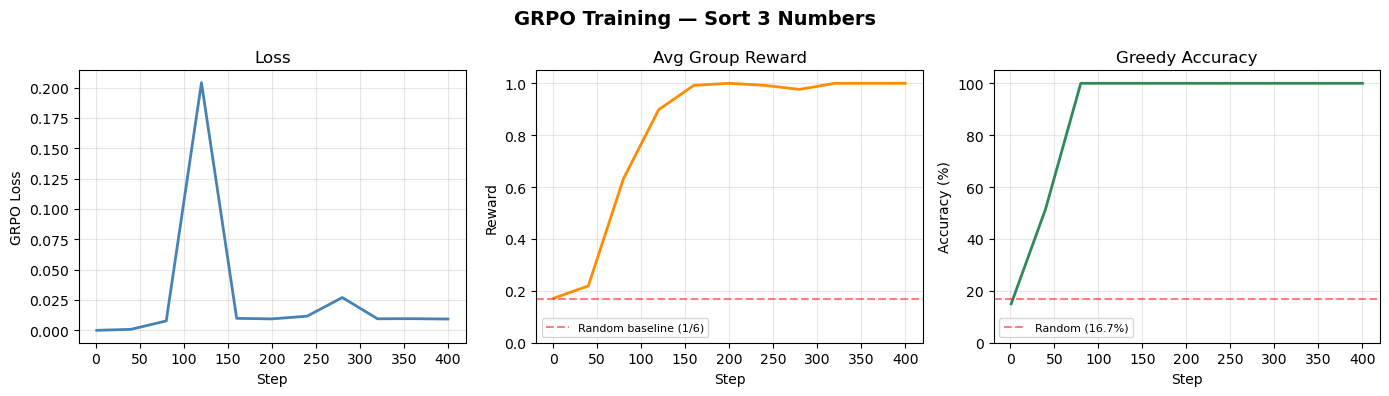

Plot saved to grpo_training.png


In [6]:
# ── Visualisation ──────────────────────────────────────────────

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle("GRPO Training — Sort 3 Numbers", fontsize=14, fontweight="bold")

steps = history["step"]

# Loss
axes[0].plot(steps, history["loss"], color="steelblue", linewidth=2)
axes[0].set_title("Loss")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("GRPO Loss")
axes[0].grid(True, alpha=0.3)

# Average Reward
axes[1].plot(steps, history["reward"], color="darkorange", linewidth=2)
axes[1].set_title("Avg Group Reward")
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Reward")
axes[1].set_ylim(0, 1.05)
axes[1].axhline(y=1/6, color="red", linestyle="--", alpha=0.5, label="Random baseline (1/6)")
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

# Accuracy
axes[2].plot(steps, [a * 100 for a in history["accuracy"]], color="seagreen", linewidth=2)
axes[2].set_title("Greedy Accuracy")
axes[2].set_xlabel("Step")
axes[2].set_ylabel("Accuracy (%)")
axes[2].set_ylim(0, 105)
axes[2].axhline(y=100/6, color="red", linestyle="--", alpha=0.5, label="Random (16.7%)")
axes[2].legend(fontsize=8)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("grpo_training.png", dpi=120, bbox_inches="tight")
plt.show()
print("Plot saved to grpo_training.png")

In [7]:
# ── Demo on concrete examples ───────────────────────────────────

trained_policy.eval()

test_cases = [
    [1, 0, 2],
    [2, 1, 0],
    [3, 7, 1],
    [0, 5, 3],
    [9, 4, 6],
    [8, 2, 5],
]

print(f"{'Input':>15}  {'Output':>10}  {'Expected':>10}  {'Correct':>8}")
print("-" * 52)

with torch.no_grad():
    for nums in test_cases:
        x      = torch.tensor(normalize_input(nums), dtype=torch.float32)
        probs  = trained_policy(x)
        pred_idx = probs.argmax().item()
        pred_perm = ALL_PERMS[pred_idx]
        output   = [nums[i] for i in pred_perm]
        expected = sorted(nums)
        correct  = "✓" if output == expected else "✗"
        print(f"{str(nums):>15}  {str(output):>10}  {str(expected):>10}  {correct:>8}")

print()
print("Probability distributions for [1, 0, 2]:")
nums = [1, 0, 2]
x    = torch.tensor(normalize_input(nums), dtype=torch.float32)
probs = trained_policy(x)
cp   = correct_perm(nums)
for i, (perm, prob) in enumerate(zip(ALL_PERMS, probs.tolist())):
    output = [nums[j] for j in perm]
    marker = " ← correct" if perm == cp else ""
    bar    = "█" * int(prob * 40)
    print(f"  {perm}→{output}  {prob:.3f}  {bar}{marker}")

          Input      Output    Expected   Correct
----------------------------------------------------
      [1, 0, 2]   [0, 1, 2]   [0, 1, 2]         ✓
      [2, 1, 0]   [0, 1, 2]   [0, 1, 2]         ✓
      [3, 7, 1]   [1, 3, 7]   [1, 3, 7]         ✓
      [0, 5, 3]   [0, 3, 5]   [0, 3, 5]         ✓
      [9, 4, 6]   [4, 6, 9]   [4, 6, 9]         ✓
      [8, 2, 5]   [2, 5, 8]   [2, 5, 8]         ✓

Probability distributions for [1, 0, 2]:
  (0, 1, 2)→[1, 0, 2]  0.001  
  (0, 2, 1)→[1, 2, 0]  0.000  
  (1, 0, 2)→[0, 1, 2]  0.998  ███████████████████████████████████████ ← correct
  (1, 2, 0)→[0, 2, 1]  0.001  
  (2, 0, 1)→[2, 1, 0]  0.000  
  (2, 1, 0)→[2, 0, 1]  0.000  
